# Import Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica DataSet

In [3]:
import load_dataset
user="Andrea"

load_dataset.set_user(user)
groundtruth_dir, dataset_dir = load_dataset.get_dirs()

groundtruth_dir:  D:\Andrea\Downloads\gzp 
dataset_dir:  D:\Andrea\Downloads\Paris120x120


In [4]:
class_names = load_dataset.get_classnames()
num_classes = len(class_names)

dataset = load_dataset.get_dataset(groundtruth_dir, dataset_dir, class_names)

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


Funzioni per la stampa di statistiche sul DB

In [5]:
import print_functions as prt

prt.print_dataset_stats(dataset)

Numero immagini del dataset:  2692
Numero di immagini nei vari landmark:  [225. 129. 266. 248. 344.  90. 205. 319. 147. 279. 440.]
Immagini good-ok-bad-junk:  [0, 1499, 0, 1193]
Per ogni landmark, quanti sono quelli good, ok, bad e junk: [[0, 117, 0, 108], [0, 61, 0, 68], [0, 182, 0, 84], [0, 130, 0, 118], [0, 236, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 144, 0, 135], [0, 265, 0, 175]]


In [6]:
#prt.print_class_good_images(dataset,0) #stampa tutte le immagini good della classe 0

# Split dei dati in training, validation, test set

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import random

Dataset Shuffle

In [8]:
#load_dataset.shuffle(dataset)

Dataset Split

In [9]:
# Da Dataset -> A X_train, X_val, X_test

# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

x_train_len = prt.dataset_len(x_train)
x_val_len = prt.dataset_len(x_val)

print(prt.dataset_len(x_train))
print(prt.dataset_len(x_val))
print(prt.dataset_len(x_test))

2154
264
274


# Data Augmentation

Definizione degli ImageDataGenerator. Gli oggetti ImageDataGenerator definiscono le trasformazioni che si faranno.
Chiamando flow(numpy_array_immagini) su ImageDataGenerator, flow restituirà un generatore di immagini transformate.

In [10]:
#oggetto ImageDataGenerator, definisce le trasformazioni
gen_settings = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=60,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False,                     
    rescale=None,
    fill_mode='nearest'
)

#ImageDataGenerator senza trasformazioni per validation set
test_val_settings = keras.preprocessing.image.ImageDataGenerator()

Ora definiamo una classe custom che prende gli ImageDataGenerator del nostro dataset, e gli usa per creare un generatore di triplette.

In [11]:
class CustomDataGenerator(object):
    
    # parametro nel costruttore: dataset_generators. Ha la solita struttura [ [[good],[ok],[bad],[junk]],  [...], ...]
    # però invece che avere le foto nei good, ok, ... ho un generatore per quella categoria che genera le trasformazioni
    
    def __init__(self, dataset_generators,batch_size) -> None:
        self.dataset_generators = dataset_generators
        self.batch_size=batch_size

    def next_train(self):
        current_class = -1
        while 1:
            anchors=[]
            positives=[]
            negatives=[]
            for i in range(self.batch_size):
                current_class = current_class+1
                current_class = current_class % num_classes
                
                _anchor,_positive,_negative = retrieve_single_triplet(self,current_class)
                anchors.append(_anchor)
                positives.append(_positive)
                negatives.append(_negative)
            
            anchors = tf.convert_to_tensor(anchors)
            positives = tf.convert_to_tensor(positives)
            negatives = tf.convert_to_tensor(negatives)

            triplet = (anchors, positives, negatives)
            yield(triplet)
        
def retrieve_single_triplet(self,current_class):
    different_class = random.randint(0, num_classes-1)
    
    while(different_class == current_class):
        different_class = random.randint(0, num_classes-1)  
            
    _anchor = next(self.dataset_generators[current_class][1])[0]
    _positive = next(self.dataset_generators[current_class][1])[0]
    _negative = next(self.dataset_generators[different_class][random.choice([1,3])])[0]    
    return _anchor,_positive,_negative

x_train, x_val, x_test sono strutture dati di immagini così disposte: [ [[good],[ok],[bad],[junk]],  [...], ...]
Sostituiamo le immagini coi generatori creati a partire da quelle immagini.

In [12]:
import numpy as np

#x_train, x_val, x_test prima contenevano array di immagini. Ora contengono generatori separati per classe e qualità
def transform_dataset(db, gen_settings):
    ds = [ [[],[],[],[]] for x in range(len(class_names))]
    for i in range(len(ds)):
        for j in [1,3]: #abbiamo solo immagini ok e junk (1 e 3) nel database
            generatore = gen_settings.flow(x=np.asarray(db[i][j]), batch_size=1) #batch size 1 per ritornare una sola img
            ds[i][j] = generatore
    return ds

x_train_gen = transform_dataset(x_train, gen_settings)
x_val_gen = transform_dataset(x_val, test_val_settings)
#x_test = transform_dataset(x_test, test_val_settings)

In [13]:
batch_size=128
#Training generator
custom_gen_train = CustomDataGenerator(x_train_gen,batch_size)
generatore_triplete_train = custom_gen_train.next_train()

#Validation generator
custom_gen_val = CustomDataGenerator(x_val_gen,batch_size)
generatore_triplete_val = custom_gen_val.next_train() 

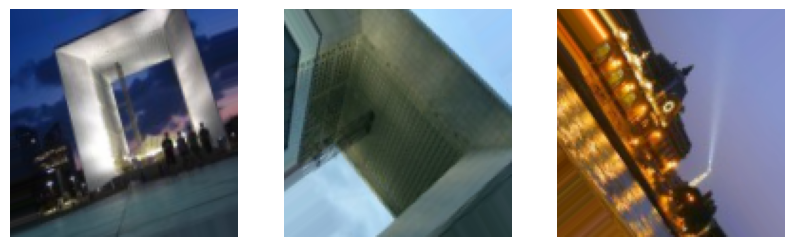

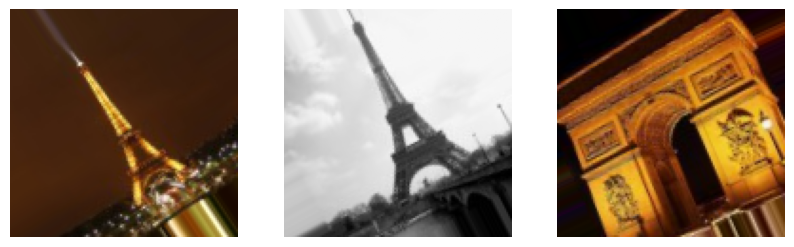

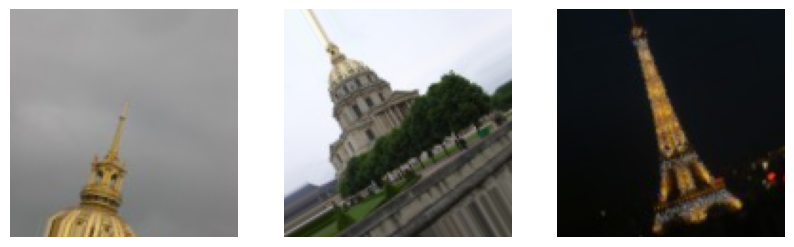

In [14]:
triplete_batch = next(generatore_triplete_train)

ancore = triplete_batch[0]
positivi = triplete_batch[1]
negativi = triplete_batch[2]

tripla1 = (ancore[0], positivi[0], negativi[0])
tripla2 = (ancore[1], positivi[1], negativi[1])
tripla3 = (ancore[2], positivi[2], negativi[2])

prt.stampa_tripletta(tripla1)
prt.stampa_tripletta(tripla2)
prt.stampa_tripletta(tripla3)

# Definizione Modello Triple

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [16]:
def get_encoder (input_shape):
    
    
    #base_cnn = resnet.ResNet50(
    #base_cnn = resnet.ResNet101(
    #base_cnn = resnet.ResNet152(
    base_cnn = EfficientNetB7(
        weights="imagenet", input_shape=input_shape, include_top=False)
    
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
        
    encode_model = tf.keras.models.Sequential([
        base_cnn,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32)
    ], name="Embedding")
    
    
    return encode_model

In [17]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [18]:
def get_siamese_network (input_shape = (120,120,3)):
    embedding_model = get_encoder(input_shape)
    input_anchor = tf.keras.layers.Input(shape= input_shape)
    input_positive = tf.keras.layers.Input(shape= input_shape)
    input_negative = tf.keras.layers.Input(shape= input_shape)
    
    embedding_anchor = embedding_model(resnet.preprocess_input(input_anchor))
    embedding_positive = embedding_model(resnet.preprocess_input(input_positive))
    embedding_negative = embedding_model(resnet.preprocess_input(input_negative))

    #embedding_anchor = embedding_model(input_anchor)
    #embedding_positive = embedding_model(input_positive)
    #embedding_negative = embedding_model(input_negative)

    distances = DistanceLayer()(
    embedding_anchor ,
    embedding_positive,
    embedding_negative ,
    )

    siamese_network =  tf.keras.models.Model(
    inputs=[input_anchor, input_positive, input_negative], outputs=distances
    )
    return siamese_network
    
siamese_network = get_siamese_network()  

In [19]:
class SiameseModel(tf.keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker =tf.keras.metrics.BinaryAccuracy(name ="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
        with tf.GradientTape() as tape:
            loss,acc = self._compute_loss(data)
        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, data):
        
        loss,acc = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss, (ap_distance<an_distance)
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker,self.acc_tracker]

In [20]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00100), weighted_metrics=[])

In [22]:
# siccome uso un generator, la dimensione del dataset diventa potenzialmente infinita
# devo definire a quanti batch corrisponde un'epoca -> steps per epoch, validation steps
steps_train=int( x_train_len/batch_size )
steps_val=int(x_val_len/batch_size)

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6, restore_best_weights='val_acc')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights='val_acc')

history = siamese_model.fit(
    generatore_triplete_train,
    steps_per_epoch=steps_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_data=generatore_triplete_val,
    validation_steps=steps_val,
    callbacks=[callback]
)


Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/Embedding/efficientnetb7/block2a_expand_activation/Sigmoid_2' defined at (most recent call last):
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Andre\AppData\Local\Temp\ipykernel_7864\3534781048.py", line 9, in <module>
      history = siamese_model.fit(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Andre\AppData\Local\Temp\ipykernel_7864\3725466504.py", line 28, in train_step
      loss,acc = self._compute_loss(data)
    File "C:\Users\Andre\AppData\Local\Temp\ipykernel_7864\3725466504.py", line 54, in _compute_loss
      ap_distance, an_distance = self.siamese_network(data)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\keras\activations.py", line 270, in swish
      return tf.nn.silu(x)
Node: 'model/Embedding/efficientnetb7/block2a_expand_activation/Sigmoid_2'
failed to allocate memory
	 [[{{node model/Embedding/efficientnetb7/block2a_expand_activation/Sigmoid_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_115108]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc test', 'loss train','loss test'], loc='upper left')
plt.show()

# Usare il Modello Allenato

Runnare questa cella solo se non si ha il modello "encoder" salvato

In [24]:
def get_encoder_with_weights(model):
    encoder=get_encoder((120,120,3))
    i=0
    for e_layer in model.layers[0].layers[9].layers:
        layer_weight= e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = get_encoder_with_weights(siamese_model)
#encoder.summary()

Runnare questa cella solo se si sono già calcolati i pesi per il modello "encoder"

In [25]:
#encoder=get_encoder((120,120,3))
#encoder.load_weights("PesiMigliori")

Funzioni per cambiare la rappresentazione da [[ [good], [ok], [bad], [junk] ],[...], ...] ad un vettore normale + vettore di label y.

In [26]:
#prende tutte le immagini good e ok da data e le mette in un array arr, con le immagini ordinate per classe crescente
def to_array(data):
    arr=[]
    for index in range(num_classes):
        arr.extend(data[index][0]) #prendo le immagini good della classe index, e le appendo in arr
        arr.extend(data[index][1]) #prendo le immagini ok della classe index, e le appendo in arr
    print("Data transformed into array")
    return arr

#array che segna dove finiscono in arr le immagini della classe i-esima
def get_levels(data):
    y_levels=[]
    previous = 0
    for index in range(num_classes):
        i_class_len = len(data[index][0])+len(data[index][1])
        y_levels.append(previous+i_class_len)
        previous = previous + i_class_len
    return y_levels

#ritorna il vettore y di label(le classi) a partire da un y_level
def get_y(y_levels):
    tot = y_levels[-1]
    y = [np.zeros(num_classes) for i in range(tot)]
    class_index = 0
    
    for i in range(tot):
        while i >= y_levels[class_index]:
            class_index = class_index + 1
        y[i][class_index] = 1
    return y

def produce_encodings(x, encoder):
    dt = tf.data.Dataset.from_tensor_slices(x)
    dt = dt.batch(1,drop_remainder=False)
    print("Encoding data...")
    return encoder.predict(dt)

Passo le immagini di training attraverso l'encoder e produco un encoding delle immagini di training

In [27]:
y_train_levels = get_levels(x_train)
x_train_array = to_array(x_train)
x_train_encoded = produce_encodings(x_train_array, encoder)

Data transformed into array
Encoding data...


Passo le immagini di test attraverso l'encoder e produco un encoding delle immagini di test

In [28]:
y_test_levels = get_levels(x_test)
x_test_array = to_array(x_test)
x_test_encoded = produce_encodings(x_test_array, encoder)

Data transformed into array
Encoding data...


Per ogni immagine di test, ottengo un vettore con le probabilità che appartenga ad una certa classe (come il layer softmax)

In [29]:
def get_predizioni(x_train_encoded, x_test_encoded, y_train_levels):
    predizioni = []
    for i in range(len(x_test_encoded)):
        distances = tf.reduce_sum(tf.square(x_train_encoded - x_test_encoded[i]), -1)

        x = []  
        for index in range(num_classes):
            if index==0:
                diClasse=distances[0:y_train_levels[index]]
            else:
                diClasse=distances[y_train_levels[index-1]:y_train_levels[index]]
            x.append( tf.math.reduce_min(diClasse) )
        distribution = tf.nn.softmax(x)
        distribution =tf.subtract(distribution,1)
        distribution = tf.negative(distribution)
        distribution= tf.divide(distribution,len(distribution)-1)

        predizioni.append(distribution.numpy().tolist())
    return predizioni

predizioni = get_predizioni(x_train_encoded, x_test_encoded, y_train_levels)

Calcolo e stampa del topk

In [30]:
from statistics import mean

def topk(num):
    x = tf.keras.metrics.TopKCategoricalAccuracy(k=num)
    x.update_state(get_y(y_test_levels),predizioni)
    return x.result().numpy()

k = [0,0,0,0] #top k=1,k=2,k=3,k=4

for i in range(len(k)):
    k[i] = topk(i+1)

print("Valori del topk:", k)
print("Valore medio del topk:", mean(k))

Valori del topk: [0.25, 0.44078946, 0.55921054, 0.6381579]
Valore medio del topk: 0.47203946


(FACOLTATIVO/NON SERVE)

Printiamo una matrice artigianale di predizioni sul test set (ci dà un idea se siamo sulla buona strada). Una matrice diagonale è l'ideale (darebbe un top k=1 uguale a 1.0). Attenzione che se il modello predice le classi con la stessa identica probabilità, nella matrice metto come predizione la prima classe nell'ordine dei class names

In [31]:
matrice = [[0 for i in range(len(predizioni[0]))] for i in range(num_classes)]

o = 0
for i in range(len(predizioni)):
    if y_test_levels[o]-1 < i:
        o = o+1
    index = 0
    m = predizioni[i][0]
    for j in range(len(predizioni[i])):
        if predizioni[i][j] > m:
            m = predizioni[i][j]
            index = j
    matrice[o][index] = matrice[o][index] + 1
        
print("Le righe sono il ground truth. Cioè riga i = classe i");
print("Le colonne sono le predizioni.\nUn buon lavoro restituisce una matrice con la diagonale piena e il resto vuoto");

for i in range(num_classes):
    print(matrice[i])

Le righe sono il ground truth. Cioè riga i = classe i
Le colonne sono le predizioni.
Un buon lavoro restituisce una matrice con la diagonale piena e il resto vuoto
[1, 2, 1, 3, 0, 0, 2, 2, 0, 0, 1]
[0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 1]
[0, 2, 6, 0, 0, 1, 3, 0, 0, 5, 1]
[1, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1]
[3, 1, 3, 3, 4, 2, 0, 2, 0, 2, 4]
[0, 0, 1, 0, 0, 5, 1, 0, 0, 0, 0]
[1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 2]
[0, 1, 2, 1, 1, 0, 1, 2, 0, 3, 2]
[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
[0, 0, 4, 0, 0, 1, 2, 0, 1, 7, 0]
[0, 0, 7, 2, 3, 1, 2, 1, 0, 2, 9]


# Salvare i Pesi

In [31]:
old_encoder = get_encoder((120,120,3))
old_encoder.load_weights("PesiMigliori")

x_train_encoded = produce_encodings(x_train_array, old_encoder)
x_test_encoded = produce_encodings(x_test_array, old_encoder)

predizioni = get_predizioni(x_train_encoded, x_test_encoded, y_train_levels)
old_k = [0,0,0,0] #top k=1,k=2,k=3,k=4

for i in range(len(old_k)):
    old_k[i] = topk(i+1)

print("Valori del topk:", k)
print("Valore medio del topk:", mean(k))

print("Valori del topk vecchio:", old_k)
print("Valore medio del topk vecchio:", mean(old_k))

if mean(k) > mean(old_k):
    print("Nuovi pesi salvati")
    encoder.save_weights("PesiMigliori")
else:
    print("Nuovi pesi NON salvati") 

Valori del topk: [0.38157895, 0.54605263, 0.6644737, 0.7697368]
Valore medio del topk: 0.59046054
Valori del topk vecchio: [0.4276316, 0.5986842, 0.67763156, 0.7565789]
Valore medio del topk vecchio: 0.61513156
Nuovi pesi NON salvati


In [32]:
encoder.save_weights("Pesi_Dell_Ultima_Run")